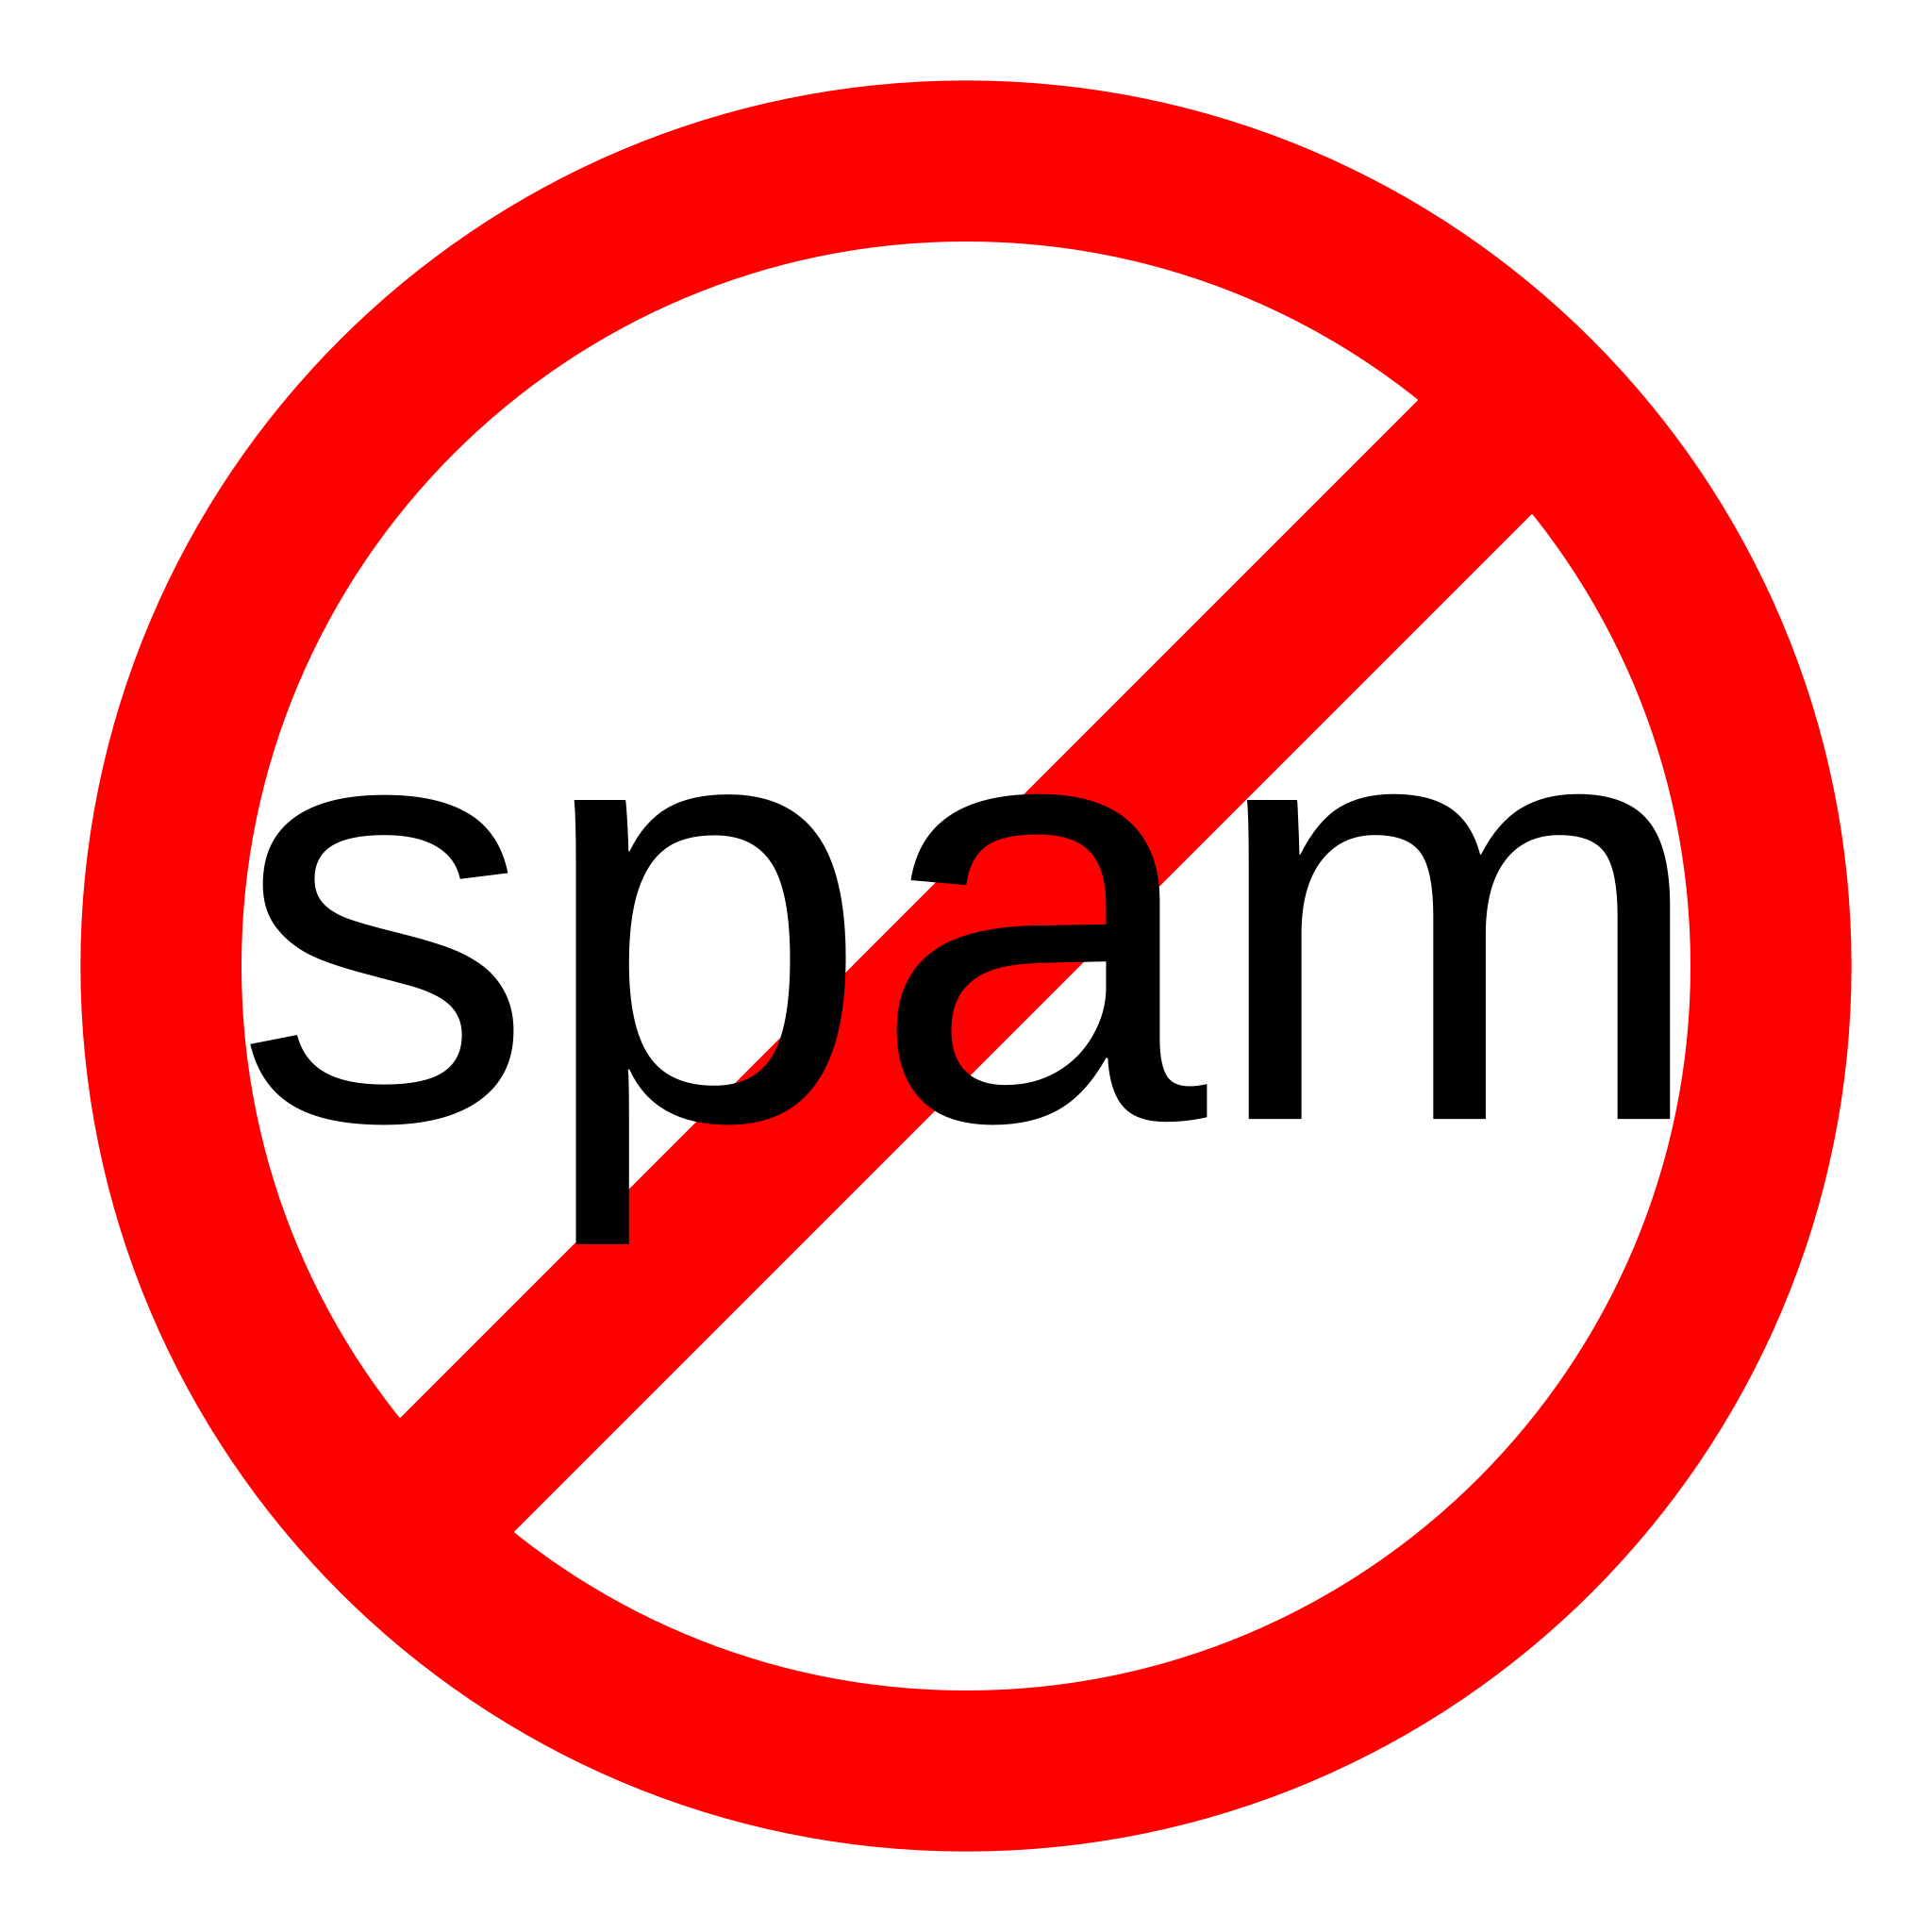

# Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

# Read and clean my data 

In [2]:
df=pd.read_csv("Spam_SMS.csv")
df=df.dropna()
df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


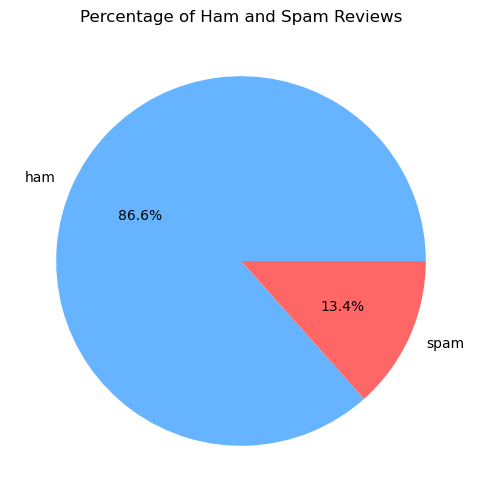

In [3]:
label_counts = df['Class'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=['ham', 'spam'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'])
plt.title('Percentage of Ham and Spam Reviews')
plt.show()

In [4]:
X=df.drop("Class",axis=1)
y=df["Class"]

In [5]:
message=X.copy()
message

,Message
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
...,...
5569,This is the 2nd time we have tried 2 contact u...
5570,Will ü b going to esplanade fr home?
5571,"Pity, * was in mood for that. So...any other s..."
5572,The guy did some bitching but I acted like i'd...


# Stemmed Spam Filter

In [6]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [7]:
ps = PorterStemmer()

message['Message'] = message['Message'].fillna('')

corpus = []
for i in range(len(message)):
    review = str(message.iloc[i, message.columns.get_loc("Message")])
    review = re.sub("[^a-zA-Z]", " ", review)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words("english")]
    review = " ".join(review)
    corpus.append(review)

In [8]:
message["Message"][4]

"Nah I don't think he goes to usf, he lives around here though"

In [9]:
corpus[4]

'nah think goe usf live around though'

In [10]:
voc_size=1000

In [11]:
one_hot_repair=[one_hot(word,voc_size) for word in corpus]
one_hot_repair[:4]
max_length = max(len(item) for item in one_hot_repair)

print(max_length)

77


# Text After pad

In [12]:
max_length
embedding_docs=pad_sequences(one_hot_repair,padding="pre",maxlen=max_length)
embedding_docs[:4]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 772,  93, 797, 814,
        275, 938, 249, 156, 695, 917, 297, 922,  63,  97, 417, 359],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 803,  46,   2, 152, 981, 552],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

# Categorical to Numeric

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) 
y[:4]

array([0, 0, 1, 0])

# Simple LSTM Model for Binary Classification

# 

In [14]:
# Define embedding vector features
embedding_vector_features = 30

# Create a simple sequential model
model = Sequential()

# Embedding layer
model.add(Embedding(voc_size, embedding_vector_features))

# Single LSTM layer
model.add(LSTM(64))  # Using fewer units

# Dropout layer to prevent overfitting
model.add(Dropout(0.3))  # Lower dropout rate

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [15]:

X_final=np.array(embedding_docs)
y_final=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=42,shuffle = True)

In [16]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8813 - loss: 0.3689 - val_accuracy: 0.9670 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9766 - loss: 0.0861 - val_accuracy: 0.9806 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9888 - loss: 0.0424 - val_accuracy: 0.9857 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9938 - loss: 0.0242 - val_accuracy: 0.9835 - val_loss: 0.0738 - learning_rate: 0.0010
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9952 - loss: 0.0241 - val_accuracy: 0.9742 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9970 - loss: 0.0139 - val_accuracy: 0.9813 - val_loss: 0.0817 - learning_rate: 2.0000e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9965 - loss

<Axes: >

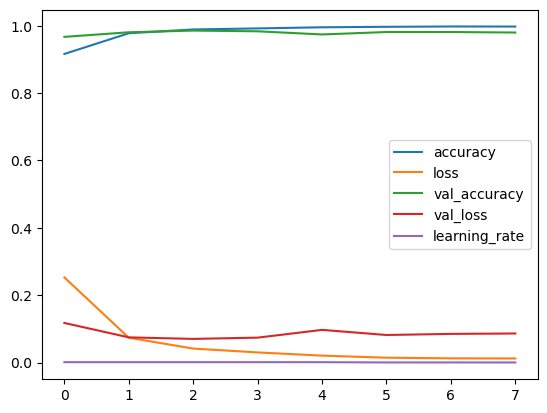

In [17]:
df2=pd.DataFrame(model.history.history)
df2.plot()

In [18]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(y_pred[:5])

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[0]
 [0]
 [0]
 [0]
 [0]]


# Confusion Matrix Heatmap

Confusion Matrix = 
 [[1200    3]
 [  17  174]] 



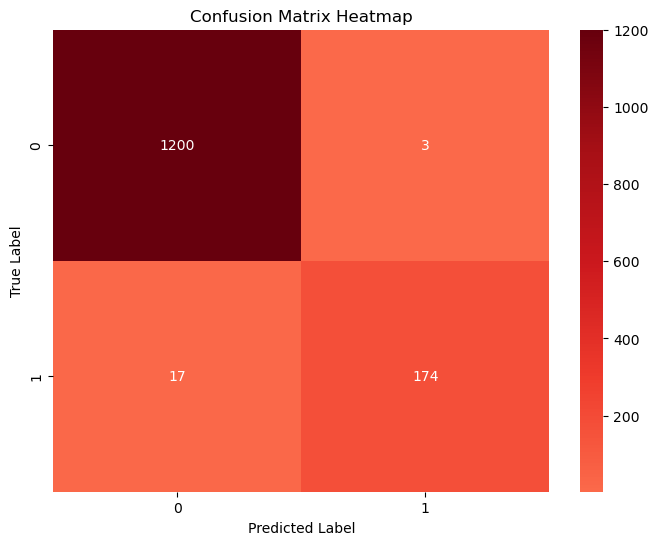

In [19]:

 
CM=confusion_matrix(y_test,y_pred)
# Assuming CM is your confusion matrix
print("Confusion Matrix = \n", CM, "\n")

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create the heatmap
sns.heatmap(CM, annot=True, fmt='d', center=0, cmap='Reds', cbar=True)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

# Model Training History Visualization


In [24]:
import pandas as pd
import plotly.express as px
import plotly.io as pio

# Ensure proper rendering in Colab
pio.renderers.default = 'kaggle'

 
# Interactive plot using Plotly Express
fig = px.line(df2, title='Model Training History')

# Show the plot
fig.show()

In [21]:
predictions = model.predict(X_test)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9869 - loss: 0.0530
Test Accuracy: 0.9856528043746948


# Testing Spam Detection with New Text Input

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer with vocabulary size of 1000
tokenizer = Tokenizer(num_words=1000)  # Set num_words to 1000
tokenizer.fit_on_texts(corpus)  # Fit on your training corpus

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Function to preprocess text
def preprocess_text(input_text):
    text = re.sub("[^a-zA-Z]", " ", input_text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert text to lowercase
    text = text.split()  # Split text into words
    text = [stemmer.stem(word) for word in text if word not in stopwords.words("english")]  # Stem the words
    text = " ".join(text)  # Join the words back into a single string
    return text

# Function to predict if the text is spam or not
def predict_spam(input_text):
    # Preprocess the new text
    processed_text = preprocess_text(input_text)
    
    # Convert the processed text into a sequence for the model
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=47)  # Use the same maxlen as in training
    
    # Use the trained model to predict
    prediction = model.predict(padded_sequence)  # Make sure to use your trained model
    
    # Output the result
    if prediction > 0.5:
        return "Not Spam"
    else:
        return "Spam"

In [23]:
# Example of using the function
new_message = "Congratulations! You've won a free ticket."
result = predict_spam(new_message)
print(f"The message is: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
The message is: Spam


# FINAL

In [25]:
# Save the model
model.save('spam_classifier_lstm.h5')

# Save the tokenizer too if used
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
